In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *
from shell.utils.record import Record

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from shell.fleet.utils.model_sharing_utils import *
from matplotlib.cm import get_cmap

logging.basicConfig(level=logging.CRITICAL)

In [3]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [10]:
dataset = "mnist"
# datasets = ["mnist", "kmnist", "fashionmnist"]
experiment_folder = "experiment_results"

# use_contrastive = True
use_contrastive = False
num_trains_per_class = 64
# seed = 0
seed = 3
# seed = 7
algo = "modular"


sync_base = True
opt_with_random = False

# experiment_name = f"modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}"
experiment_name = f"lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_False"
# base_experiment_name = "vanilla_modular_save_freq_10"
# base_experiment_name = "vanilla_fix_bug_compute_loss_encodev2"
base_experiment_name = "vanilla_jorge_setting"
# base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
# seeds = [1]
# tasks = [4]
# agent_ids = None
# ax=None
# sync_bases = [True]
# opt_with_randoms = [False]



def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

save_dirs = {}
save_dirs['modmod'] = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
save_dirs['base_mod']  = get_save_dir(experiment_folder, base_experiment_name,  
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
save_dirs['base_mono']  = get_save_dir(experiment_folder, base_experiment_name,  
                        dataset, 'monolithic', num_trains_per_class, use_contrastive, seed)

## Divergence

In [ ]:
def compute_divergence(save_dir, task_id):
    fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
    fleet.load_model_from_ckpoint(task_ids=task_id)
    basis = [f'components.{i}.weight' for i in range(fleet.num_init_tasks)]
    basis += [f'components.{i}.bias' for i in range(fleet.num_init_tasks)]
    div = Record("debug_modmod_result_div")
    for agent in fleet.agents:
        for agent2 in fleet.agents:
            if agent.node_id == agent2.node_id:
                continue
            agent_div = diff_models(agent.net.state_dict(), agent2.net.state_dict(), basis)
            agent_div['avg'] = sum(agent_div.values()) / len(agent_div)
            div.write(
               {'agent_1': agent.node_id, 'agent_2': agent2.node_id} | 
                agent_div)
    return div


In [ ]:
num_init_tasks = 4
num_tasks = 10
exp_divs = {}
for exp_name, save_dir in save_dirs.items():
    divs = {}
    for task_id in range(num_init_tasks, num_tasks):
        task_div = compute_divergence(save_dir, task_id).df
        div_m, div_std = task_div['avg'].mean(), task_div['avg'].std()
        divs[task_id] = (div_m, div_std)
    exp_divs[exp_name] = divs

In [ ]:
def plot_div(exp_divs):
    num_exp = len(exp_divs)
    exp_names = list(exp_divs.keys())
    task_ids = list(next(iter(exp_divs.values())).keys())
    num_tasks = len(task_ids)

    # Width of a bar
    bar_width = 0.8 / num_exp  # Adjust this as needed

    # Create figure and axes
    fig, ax = plt.subplots()

    # Generate a colormap
    cmap = get_cmap('tab20', num_exp)  # You can change 'viridis' to any other colormap
    colors = {exp_name: cmap(i) for i, exp_name in enumerate(exp_names)}
    print(colors)

    # Loop over experiments and tasks to plot
    for exp_index, (exp_name, divs) in enumerate(exp_divs.items()):
        offsets = np.arange(len(task_ids))  # Base x positions for each task_id
        for task_index, (task_id, (div_m, div_std)) in enumerate(divs.items()):
            # Calculate offset for this experiment
            offset = (exp_index - num_exp / 2) * bar_width + bar_width / 2
            pos = offsets[task_index] + offset
            
            # Plotting
            plt.bar(pos, div_m, yerr=div_std, width=bar_width, color=colors[exp_name],
                    label=f'{exp_name}' if task_index == 0 else "", align='center')

    # Improving the plot
    ax.set_xticks(np.arange(len(task_ids)))
    ax.set_xticklabels(task_ids)
    ax.set_ylim(0.001, 0.01)

    # Create a legend for the experiments
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates in legend
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('Task ID')
    plt.ylabel('Divergence Measure')
    plt.title('Divergence Measures by Task and Experiment')

    plt.show()


In [ ]:
# exp_divs

In [ ]:
plot_div(exp_divs)

## Shared Module Compatibility

In [ ]:
def compute_no_dependent_modules(save_dir, task_id):
    fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)
    fleet.load_records()
    fleet.load_model_from_ckpoint(task_ids=task_id-1)
    fleet.communicate(task_id=task_id, end_epoch=None, comm_freq=None, num_epochs=None)
    record = Record('debug_modmod_result_depedent_modules')
    for agent in fleet.agents:
        module_list = agent.get_module_list()
        if len(module_list) == 0:
            continue
        chosen_id = agent.choose_best_module_from_neighbors(module_list)
        chosen = module_list[chosen_id]
        record.write(
            {
            'agent': agent.node_id,
            'chosen_module_id': chosen['module_id'],
            'task_id': task_id,
            'task_sim': chosen['task_sim'],
            })
    return record

In [ ]:
seeds = [1, 2, 3, 4, 5, 6, 7]
seed_chosen_module_id = []
for seed_id in seeds:
    save_dirs = {}
    save_dirs['modmod'] = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed_id)

    dfs = []
    for i in range(5, 10):
        dfs.append(compute_no_dependent_modules(save_dirs['modmod'], i).df)

    df = pd.concat(dfs)
    mean_chosen_module_id = df.groupby('task_id').mean().reset_index()
    seed_chosen_module_id.append(mean_chosen_module_id)

In [ ]:
dfs = []
for seed, df in enumerate(seed_chosen_module_id):
    df["seed"] = seed
    dfs.append(df)

concat_df = pd.concat(dfs).reset_index(drop=True)

# Aggregating results
agg_df = concat_df.groupby("task_id").agg({"chosen_module_id": "mean", "task_sim": "mean"}).reset_index()

In [ ]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Bar plot of chosen_module_id with respect to task_id
axs[0].bar(agg_df["task_id"], agg_df["chosen_module_id"], color='skyblue')
axs[0].set_title('Average Chosen Module ID by Task ID')
axs[0].set_xlabel('Task ID')
axs[0].set_ylabel('Chosen Module ID')

# Bar plot of task_sim
axs[1].bar(agg_df["task_id"], agg_df["task_sim"], color='lightgreen')
axs[1].set_title('Average Task Similarity by Task ID')
axs[1].set_xlabel('Task ID')
axs[1].set_ylabel('Task Similarity')

plt.tight_layout()
plt.show()

## Softmax

In [ ]:
# save_dir = save_dirs['modmod']
# fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

In [11]:
save_dir = save_dirs['base_mod']
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)



{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.5}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0, 'sync_base': False, 'pre_or_post_comm': 'post'}, 'seed': 3, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_jorge_setting', 'parallel': True, 'num_init_tasks': 4, 'overwrite': False, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': False, 'use_ood_separation_loss': False, 'lambda_ood': 2.0, 'delta_ood': 1.0}}
i_size 28
num_class

In [21]:
agent =  fleet.agents[0]
task_id = 5
fleet.load_records()
fleet.load_model_from_ckpoint(task_ids=task_id)
net = agent.net
s = net.softmax(net.structure[task_id][:net.num_components, :]).cpu().detach().numpy()
s

array([[0.10796846, 0.21458721, 0.20620917, 0.18948695],
       [0.16130501, 0.14310163, 0.13404725, 0.14619054],
       [0.20265912, 0.12204544, 0.13838975, 0.14544396],
       [0.1607595 , 0.12558734, 0.1329544 , 0.14395985],
       [0.1115187 , 0.2206218 , 0.22572438, 0.20850234],
       [0.25578922, 0.17405656, 0.1626751 , 0.1664163 ]], dtype=float32)

In [22]:
agent.agent.dynamic_record.df

,task_id,best_candidate_idx,num_candidates,best_improvement,num_components,add_new_module
0,4,4,1,0.091954,5,True
1,5,5,1,0.555556,6,True
2,6,6,1,0.146341,7,True
3,7,7,1,0.000000,7,False
4,8,7,1,0.342857,8,True
5,9,8,1,0.031579,8,False


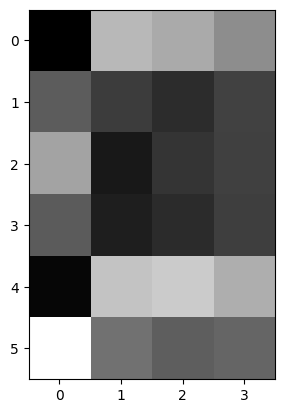

In [23]:
plt.imshow(s, cmap='gray')

## Analysis

At the beginning of each task, compute
- Basis module divergence.
- External module dependency on the shared module:
    - No. of sender's modules at the source task time.
    - Actual avg linear weight on non-basis modules at source task time.

- Plot the no. of modules over time